In [1]:
import re
import matplotlib.pyplot as plt
import string
#111from nltk.corpus import stopwords
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.utils import simple_preprocess
import gensim
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

In [2]:
corpus_data = pd.read_csv("C:/Users/canimaginerc/Desktop/TURTED.csv", delimiter="\t")

In [3]:
#Pulled data from CSV
corpus_data.head(15)

,id,tw_text,emotion
0,1,Bu akşam eys show gece modunda Papatyam var ç...,korku
1,2,Diyarbekir Surları Mardinkapı'nın dıştan yakın...,korku
2,3,- Bu akşam... Deep Purple Santana The Beatles ...,korku
3,4,@ailenizdenefruz Bakalım akşam kim kuscak,korku
4,5,"Şuan Endonezyalı, Taylandlı ve Filipinli Blink...",korku
5,6,Son duyuru: Bu akşam saat 20:00'da Pub Station...,korku
6,7,@AltokZkan Akşam Beşiktaş nakit alınır,korku
7,8,@Fox2016Tv Fatih Portakal kardeşim akşam haber...,korku
8,9,@dygggl Kesin eksik birseyler var yolda aklımı...,korku
9,10,Bir akşam mahalleden arkadaşımın eğlencesi var...,korku


In [4]:
#Length of corpus
len(corpus_data)

194240

In [5]:
#Getting emotions variants, also we will use these at the end of the model while testing manuel
emotions = corpus_data['emotion'].unique()

In [6]:
#The distribution of data
corpus_data.groupby('emotion').nunique()

,id,tw_text
emotion,,
korku,32875,31719
mutluluk,27659,26574
tiksinme,31869,30477
öfke,44173,42650
üzüntü,34130,32710
şaşırma,23534,22580


In [7]:
#Our corpus without 'id' column, dataFrame already doing that
corpus_data = corpus_data[['tw_text','emotion']]
corpus_data.head()

,tw_text,emotion
0,Bu akşam eys show gece modunda Papatyam var ç...,korku
1,Diyarbekir Surları Mardinkapı'nın dıştan yakın...,korku
2,- Bu akşam... Deep Purple Santana The Beatles ...,korku
3,@ailenizdenefruz Bakalım akşam kim kuscak,korku
4,"Şuan Endonezyalı, Taylandlı ve Filipinli Blink...",korku


In [8]:
#Check for null instances
corpus_data["tw_text"].isnull().sum()

0

In [10]:
def simplyfyData(data):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    data = re.sub('\S*@\S*\s?', '', data)
    data = re.sub('\s+', ' ', data)
    data = re.sub("\'", "", data)  
    return data

In [11]:
container = []
data_to_list = corpus_data['tw_text'].values.tolist()
for i in range(len(data_to_list)):
    container.append(simplyfyData(data_to_list[i]))
list(container[:5])

['Bu akşam eys show gece modunda Papatyam var çooook eğlenceli kaçmaz saat sayıyorum 8 saat kaldıııııı konuklar mükemmel bu program kaçmaz kaçıranda PİŞMAN OLUR NEEET #iremderici #papatyam #eysshow #eysgecemodu #kaçırmayın #5nisan #çokeğlenicez ❤❤❤❤ ',
 'Diyarbekir Surları Mardinkapının dıştan yakın çekim görünümü, O zamanlar sabah kapıların açılıp akşam kapandığı için mutlaka kapının önünde bir asker veya nöbetçi dururdu. Diyarbekir 1904 ',
 '- Bu akşam... Deep Purple Santana The Beatles Jimi Hendrix Cream Jefferson Airplane Led Zeppelin Iron Butterfly Şarkıları ve ‘in sunumuyla 17:05’te ‘te canlı yayındayız... ',
 'Bakalım akşam kim kuscak',
 'Şuan Endonezyalı, Taylandlı ve Filipinli Blinkler akşam yemeklerini yedikten sonra birden abandılar galiba ki beğenileri bile sildirdiler helal olsun aq']

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data_words = list(sent_to_words(container))

print(data_words[:10])

[['bu', 'aksam', 'eys', 'show', 'gece', 'modunda', 'papatyam', 'var', 'cooook', 'eglenceli', 'kacmaz', 'saat', 'sayıyorum', 'saat', 'kaldıııııı', 'konuklar', 'mukemmel', 'bu', 'program', 'kacmaz', 'kacıranda', 'pisman', 'olur', 'neeet', 'iremderici', 'papatyam', 'eysshow', 'eysgecemodu', 'kacırmayın', 'nisan', 'cokeglenicez'], ['diyarbekir', 'surları', 'mardinkapının', 'dıstan', 'yakın', 'cekim', 'gorunumu', 'zamanlar', 'sabah', 'kapıların', 'acılıp', 'aksam', 'kapandıgı', 'icin', 'mutlaka', 'kapının', 'onunde', 'bir', 'asker', 'veya', 'nobetci', 'dururdu', 'diyarbekir'], ['bu', 'aksam', 'deep', 'purple', 'santana', 'the', 'beatles', 'jimi', 'hendrix', 'cream', 'jefferson', 'airplane', 'led', 'zeppelin', 'iron', 'butterfly', 'sarkıları', 've', 'in', 'sunumuyla', 'te', 'te', 'canlı', 'yayındayız'], ['bakalım', 'aksam', 'kim', 'kuscak'], ['suan', 'endonezyalı', 'taylandlı', 've', 'filipinli', 'blinkler', 'aksam', 'yemeklerini', 'yedikten', 'sonra', 'birden', 'abandılar', 'galiba', 'ki', 

In [13]:
len(data_words)

194240

In [14]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [15]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])
data = np.array(data)

['bu aksam eys show gece modunda papatyam var cooook eglenceli kacmaz saat sayıyorum saat kaldıııııı konuklar mukemmel bu program kacmaz kacıranda pisman olur neeet iremderici papatyam eysshow eysgecemodu kacırmayın nisan cokeglenicez', 'diyarbekir surları mardinkapının dıstan yakın cekim gorunumu zamanlar sabah kapıların acılıp aksam kapandıgı icin mutlaka kapının onunde bir asker veya nobetci dururdu diyarbekir', 'bu aksam deep purple santana the beatles jimi hendrix cream jefferson airplane led zeppelin iron butterfly sarkıları ve in sunumuyla te te canlı yayındayız', 'bakalım aksam kim kuscak', 'suan endonezyalı taylandlı ve filipinli blinkler aksam yemeklerini yedikten sonra birden abandılar galiba ki begenileri bile sildirdiler helal olsun aq']


In [16]:
labels = np.array(corpus_data['emotion'])
emotesToNumber = []
for i in range(len(labels)):
    if labels[i] == 'korku':
        emotesToNumber.append(0)
    elif labels[i] == 'mutluluk':
        emotesToNumber.append(1)
    elif labels[i] == 'tiksinme':
        emotesToNumber.append(2)
    elif labels[i] == 'öfke':
        emotesToNumber.append(3)
    elif labels[i] == 'üzüntü':
        emotesToNumber.append(4)
    elif labels[i] == 'şaşırma':
        emotesToNumber.append(5)
emotesToNumber = np.array(emotesToNumber)
labels = tf.keras.utils.to_categorical(emotesToNumber, 6, dtype="float32")
del emotesToNumber

In [17]:
len(labels)

194240

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
instances = pad_sequences(sequences, maxlen=max_len)
print(instances)

[[   0    0    0 ... 1691   58  212]
 [   0    0    0 ...    1 1687  297]
 [   0    0    0 ...  783  783  865]
 ...
 [   0    0    0 ... 1837   88  361]
 [   0    0    0 ... 3297 3405  361]
 [   0    0    0 ...  183  361   23]]


In [19]:
print(labels)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(instances,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

145680 48560 145680 48560


In [25]:
model = Sequential()
model.add(layers.Embedding(max_words, 20))
model.add(layers.LSTM(15,dropout=0.5))
model.add(layers.Dense(6,activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

#Do not use the 'save_freq', it's shows the warnings. The program works same but it needs more detail in the code.
checkpoint1 = ModelCheckpoint("CSE5093_Assigment4_2020900016.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=25,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/25
4553/4553 [==============================] - ETA: 0s - loss: 1.1349 - accuracy: 0.5840
Epoch 00001: val_accuracy improved from -inf to 0.72430, saving model to CSE5093_Assigment4_2020900016.hdf5
4553/4553 [==============================] - 224s 49ms/step - loss: 1.1349 - accuracy: 0.5840 - val_loss: 0.7892 - val_accuracy: 0.7243
Epoch 2/25
4553/4553 [==============================] - ETA: 0s - loss: 0.8172 - accuracy: 0.7136
Epoch 00002: val_accuracy improved from 0.72430 to 0.73612, saving model to CSE5093_Assigment4_2020900016.hdf5
4553/4553 [==============================] - 214s 47ms/step - loss: 0.8172 - accuracy: 0.7136 - val_loss: 0.7370 - val_accuracy: 0.7361
Epoch 3/25
4552/4553 [============================>.] - ETA: 0s - loss: 0.7724 - accuracy: 0.7237
Epoch 00003: val_accuracy improved from 0.73612 to 0.73948, saving model to CSE5093_Assigment4_2020900016.hdf5
4553/4553 [==============================] - 220s 48ms/step - loss: 0.7724 - accuracy: 0.7237 - val_loss

In [26]:
#history = keras.models.load_model("CSE5093_Assigment4_2020900016.hdf5")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Accuracy: %f' % (test_acc*100))

1518/1518 - 15s - loss: 0.6425 - accuracy: 0.7446
Accuracy: 74.460459


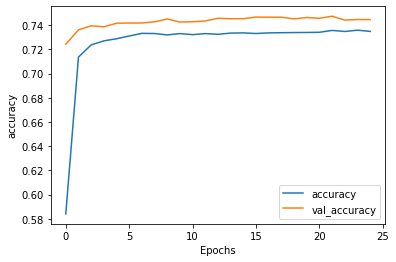

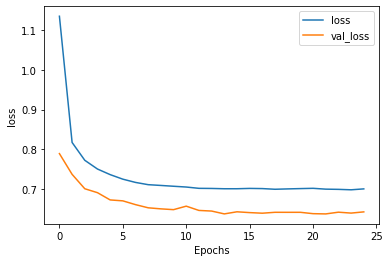

In [27]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [33]:
text = ['çok korkuyorum, dersten kalabilirim']
emotions = ['korku', 'öfke', 'üzüntü', 'tiksinme', 'mutluluk', 'şaşırma']
sequence = tokenizer.texts_to_sequences(text)
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
emotions[np.argmax(pred)-1]

'korku'